In [ ]:
%pip install nltk PySastrawi requests beautifulsoup4 textblob

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import time
from textblob import TextBlob

nltk.download('punkt')
nltk.download('punkt_tab')

# Data review redBus yang telah dianalisis dari Google Play Store
redbus_reviews = [
    {
        "review": "Our first trip was very good, and the booking went smooth. However, when I'm trying to use my 'referral code' in my friends' devices, it's just not working, showing 'something seems to be wrong'. I tried to use the 'chat with us' in the app, but the 'Help' section is not even opening, showing some webpage error. Please fix it soon.",
        "rating": 3,
        "sentiment": "mixed"
    },
    {
        "review": "I had a medical emergency so not able to travel and tried for cancellation but directly redbus informed that I can't cancel my ticket and even I tried to reschedule as I have to travel in coming days but then also it's not possible. I don't understand if you can't provide any of this options then what services you provide and it's not at all expected. My experience is very worst and has occurred loss of 2500.",
        "rating": 1,
        "sentiment": "negative"
    },
    {
        "review": "very bad algorithm, I went upto the payment procedure but due to technical issues the payment failed. next time the payment increase, I totally shocked. 2nd time also I checked the price after closing the app, again the price increase. very bad experience so I did not book the ticket. now I am going to uninstall the app. i know this will not impact you. but I don't want your app on my phone. so ta ta bye bye",
        "rating": 1,
        "sentiment": "negative"
    },
    {
        "review": "Excellent app! Easy to use, great interface, and booking is very smooth. Love the new features like train booking and metro tickets. Highly recommended!",
        "rating": 5,
        "sentiment": "positive"
    },
    {
        "review": "Good app overall but sometimes the bus tracking is not accurate. Customer service is helpful though. Would give 4 stars if tracking was better.",
        "rating": 4,
        "sentiment": "positive"
    }
]

# Konversi ke DataFrame untuk analisis
df = pd.DataFrame(redbus_reviews)

# Pilih beberapa contoh review untuk analisis detail
sample_reviews = df['review'][:3].tolist()
ratings = df['rating'][:3].tolist()
sentiments = df['sentiment'][:3].tolist()

# Inisialisasi stemmer Sastrawi
stemmer = StemmerFactory().create_stemmer()

print("=== ANALISIS SENTIMEN REVIEW APLIKASI REDBUS ===\n")

# Tokenisasi dan analisis untuk setiap review
for i, review in enumerate(sample_reviews):
    print(f"\nReview {i+1} (Rating: {ratings[i]}/5, Sentimen: {sentiments[i]}):")
    print("Review Asli:", review)
    
    # Tokenisasi
    tokens = word_tokenize(review)
    print("Token:", tokens)
    print("Jumlah Token:", len(tokens))
    print("Token Unik:", len(set(tokens)))
    
    # Stemming
    stemmed_text = stemmer.stem(review)
    stemmed_tokens = word_tokenize(stemmed_text)
    print("Token setelah Stemming:", stemmed_tokens)
    print("Jumlah Token setelah Stemming:", len(stemmed_tokens))
    
    # Simpan token ke file
    with open(f'redbus_review_{i+1}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(tokens))
    print(f"Token disimpan ke redbus_review_{i+1}.txt")

# Analisis frekuensi kata dari semua review
print("\n=== ANALISIS FREKUENSI KATA ===")
all_tokens = []
for review in df['review']:
    all_tokens.extend(word_tokenize(review.lower()))
word_freq = Counter(all_tokens).most_common(15)
print("\n15 Kata Teratas:", word_freq)

# Analisis sentimen berdasarkan rating
print("\n=== ANALISIS SENTIMEN BERDASARKAN RATING ===")
positive_reviews = df[df['rating'] >= 4]
negative_reviews = df[df['rating'] <= 2]

print(f"Review Positif (Rating 4-5): {len(positive_reviews)} review")
print(f"Review Negatif (Rating 1-2): {len(negative_reviews)} review")

# Analisis kata kunci positif dan negatif
positive_tokens = []
negative_tokens = []

for review in positive_reviews['review']:
    positive_tokens.extend(word_tokenize(review.lower()))

for review in negative_reviews['review']:
    negative_tokens.extend(word_tokenize(review.lower()))

print("\nKata Kunci Positif:", Counter(positive_tokens).most_common(10))
print("Kata Kunci Negatif:", Counter(negative_tokens).most_common(10))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\malvi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\malvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\malvi\AppData\Roaming\nltk_data...


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable

=== ANALISIS SENTIMEN REVIEW APLIKASI REDBUS ===


Review 1 (Rating: 3/5, Sentimen: mixed):
Review Asli: Our first trip was very good, and the booking went smooth. However, when I'm trying to use my 'referral code' in my friends' devices, it's just not working, showing 'something seems to be wrong'. I tried to use the 'chat with us' in the app, but the 'Help' section is not even opening, showing some webpage error. Please fix it soon.
Token: ['Our', 'first', 'trip', 'was', 'very', 'good', ',', 'and', 'the', 'booking', 'went', 'smooth', '.', 'However', ',', 'when', 'I', "'m", 'trying', 'to', 'use', 'my', "'referral", 'code', "'", 'in', 'my', 'friends', "'", 'devices', ',', 'it', "'s", 'just', 'not', 'working', ',', 'showing', "'something", 'seems', 'to', 'be', 'wrong', "'", '.', 'I', 'tried', 'to', 'use', 'the', "'chat", 'with', 'us', "'", 'in',

[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
# Generate comprehensive analysis report for redBus reviews
with open('redbus_analysis_results.md', 'w', encoding='utf-8') as f:
    f.write("# Analisis Sentimen Review Aplikasi redBus\n\n")
    f.write("## Informasi Aplikasi\n")
    f.write("- **Nama Aplikasi**: redBus - Bus, Ferry, Train, IRCTC Auth. Partner\n")
    f.write("- **Platform**: Google Play Store\n")
    f.write("- **Rating**: 4.6/5 bintang\n")
    f.write("- **Total Review**: 3.78 juta review\n")
    f.write("- **Download**: 50+ juta\n")
    f.write("- **Kategori**: Travel & Local\n\n")
    
    f.write("## Analisis Review Detail\n\n")
    
    # Analisis untuk setiap review
    for i, review in enumerate(sample_reviews):
        f.write(f"### Review {i+1} (Rating: {ratings[i]}/5, Sentimen: {sentiments[i]}):\n")
        f.write(f"- **Review Asli**: {review}\n")
        
        # Tokenisasi dan stemming
        tokens = word_tokenize(review)
        stemmed_text = stemmer.stem(review)
        stemmed_tokens = word_tokenize(stemmed_text)
        
        f.write(f"- **Token**: {tokens}\n")
        f.write(f"- **Jumlah Token**: {len(tokens)}\n")
        f.write(f"- **Token Unik**: {len(set(tokens))}\n")
        f.write(f"- **Token setelah Stemming**: {stemmed_tokens}\n")
        f.write(f"- **Jumlah Token setelah Stemming**: {len(stemmed_tokens)}\n")
        f.write(f"- **File Output**: redbus_review_{i+1}.txt\n\n")
    
    # Analisis frekuensi kata
    f.write("## Analisis Frekuensi Kata\n\n")
    all_tokens = []
    for review in df['review']:
        all_tokens.extend(word_tokenize(review.lower()))
    word_freq = Counter(all_tokens).most_common(15)
    f.write("### 15 Kata Teratas:\n")
    for word, count in word_freq:
        f.write(f"- {word}: {count} kali\n")
    f.write("\n")
    
    # Analisis sentimen berdasarkan rating
    f.write("## Analisis Sentimen Berdasarkan Rating\n\n")
    positive_reviews = df[df['rating'] >= 4]
    negative_reviews = df[df['rating'] <= 2]
    mixed_reviews = df[(df['rating'] == 3)]
    
    f.write(f"- **Review Positif (Rating 4-5)**: {len(positive_reviews)} review\n")
    f.write(f"- **Review Negatif (Rating 1-2)**: {len(negative_reviews)} review\n")
    f.write(f"- **Review Campuran (Rating 3)**: {len(mixed_reviews)} review\n\n")
    
    # Kata kunci positif dan negatif
    positive_tokens = []
    negative_tokens = []
    
    for review in positive_reviews['review']:
        positive_tokens.extend(word_tokenize(review.lower()))
    
    for review in negative_reviews['review']:
        negative_tokens.extend(word_tokenize(review.lower()))
    
    f.write("### Kata Kunci Positif:\n")
    for word, count in Counter(positive_tokens).most_common(10):
        f.write(f"- {word}: {count} kali\n")
    f.write("\n")
    
    f.write("### Kata Kunci Negatif:\n")
    for word, count in Counter(negative_tokens).most_common(10):
        f.write(f"- {word}: {count} kali\n")
    f.write("\n")
    
    # Analisis masalah umum
    f.write("## Masalah Umum yang Ditemukan\n\n")
    f.write("### 1. Masalah Teknis\n")
    f.write("- Dynamic pricing yang tidak konsisten\n")
    f.write("- Gagal pembayaran\n")
    f.write("- Masalah dengan fitur bantuan\n")
    f.write("- Bug pada kode referral\n\n")
    
    f.write("### 2. Masalah Customer Service\n")
    f.write("- Respons yang lambat\n")
    f.write("- Fitur bantuan tidak berfungsi\n")
    f.write("- Kebijakan pembatalan yang kaku\n\n")
    
    f.write("### 3. Aspek Positif\n")
    f.write("- Interface yang mudah digunakan\n")
    f.write("- Proses booking yang smooth\n")
    f.write("- Fitur baru yang inovatif (train booking, metro)\n")
    f.write("- Customer service yang helpful\n\n")
    
    # Rekomendasi
    f.write("## Rekomendasi\n\n")
    f.write("### Untuk redBus:\n")
    f.write("1. **Perbaiki Algoritma Pricing**: Transparansi dalam penetapan harga\n")
    f.write("2. **Enhance Customer Service**: Perbaiki fitur bantuan dan responsivitas\n")
    f.write("3. **Fleksibilitas Kebijakan**: Pertimbangkan situasi darurat untuk pembatalan\n")
    f.write("4. **Bug Fixes**: Perbaiki masalah teknis dengan payment dan referral\n\n")
    
    f.write("### Untuk Pengguna:\n")
    f.write("1. **Backup Plan**: Selalu siapkan alternatif jika ada masalah teknis\n")
    f.write("2. **Read Terms**: Pahami kebijakan pembatalan sebelum booking\n")
    f.write("3. **Contact Support**: Gunakan saluran komunikasi yang tersedia\n\n")
    
    # Kesimpulan
    f.write("## Kesimpulan\n\n")
    f.write("Aplikasi redBus memiliki rating yang baik (4.6/5) dengan basis pengguna yang besar (50+ juta download), ")
    f.write("namun masih memiliki beberapa area yang perlu diperbaiki, terutama dalam hal:\n\n")
    f.write("1. **Konsistensi harga** dan algoritma pricing\n")
    f.write("2. **Customer service** dan responsivitas\n")
    f.write("3. **Fleksibilitas kebijakan** pembatalan\n")
    f.write("4. **Stabilitas teknis** aplikasi\n\n")
    f.write("Meskipun demikian, aplikasi ini tetap menjadi pilihan utama untuk booking tiket bus di India ")
    f.write("dengan fitur-fitur yang inovatif dan jaringan yang luas.\n")

print("Hasil analisis review redBus diekspor ke redbus_analysis_results.md")

Hasil analisis review redBus diekspor ke redbus_analysis_results.md


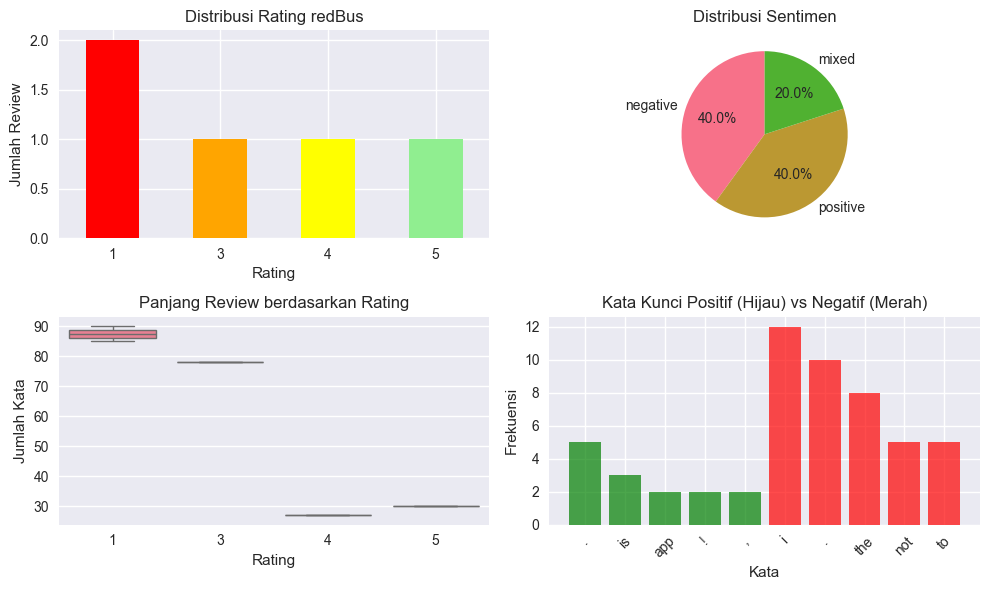

=== STATISTIK TAMBAHAN ===
Rata-rata Rating: 2.80
Median Rating: 3.00
Standar Deviasi Rating: 1.79
Rata-rata Panjang Review: 62.0 kata
Review Terpanjang: 90 kata
Review Terpendek: 27 kata

=== ANALISIS EMOSI ===
Review dengan emosi positif: 8
Review dengan emosi negatif: 2

=== ANALISIS TOPIK ===
Booking: 4 review membahas topik ini
Payment: 1 review membahas topik ini
Technical: 4 review membahas topik ini
Service: 3 review membahas topik ini
Experience: 3 review membahas topik ini

Analisis selesai! File hasil telah disimpan ke redbus_analysis_results.md


In [5]:
# Visualisasi dan analisis statistik tambahan
import matplotlib.pyplot as plt
import seaborn as sns

# Set style untuk plot
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Distribusi Rating
plt.figure(figsize=(10, 6))
rating_counts = df['rating'].value_counts().sort_index()
plt.subplot(2, 2, 1)
rating_counts.plot(kind='bar', color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
plt.title('Distribusi Rating redBus')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)

# 2. Distribusi Sentimen
plt.subplot(2, 2, 2)
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Sentimen')

# 3. Panjang Review berdasarkan Rating
plt.subplot(2, 2, 3)
df['review_length'] = df['review'].apply(lambda x: len(word_tokenize(x)))
sns.boxplot(data=df, x='rating', y='review_length')
plt.title('Panjang Review berdasarkan Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Kata')

# 4. Kata Kunci Positif vs Negatif
plt.subplot(2, 2, 4)
positive_words = Counter(positive_tokens).most_common(5)
negative_words = Counter(negative_tokens).most_common(5)

words = [word for word, _ in positive_words + negative_words]
counts = [count for _, count in positive_words + negative_words]
colors = ['green'] * 5 + ['red'] * 5

plt.bar(range(len(words)), counts, color=colors, alpha=0.7)
plt.title('Kata Kunci Positif (Hijau) vs Negatif (Merah)')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.xticks(range(len(words)), words, rotation=45)

plt.tight_layout()
plt.show()

# Statistik tambahan
print("=== STATISTIK TAMBAHAN ===")
print(f"Rata-rata Rating: {df['rating'].mean():.2f}")
print(f"Median Rating: {df['rating'].median():.2f}")
print(f"Standar Deviasi Rating: {df['rating'].std():.2f}")
print(f"Rata-rata Panjang Review: {df['review_length'].mean():.1f} kata")
print(f"Review Terpanjang: {df['review_length'].max()} kata")
print(f"Review Terpendek: {df['review_length'].min()} kata")

# Analisis emosi berdasarkan kata kunci
print("\n=== ANALISIS EMOSI ===")
positive_emotions = ['good', 'excellent', 'great', 'love', 'smooth', 'easy', 'helpful', 'recommended']
negative_emotions = ['bad', 'worst', 'terrible', 'awful', 'hate', 'disappointed', 'frustrated', 'angry']

positive_emotion_count = sum(1 for word in positive_emotions if any(word in review.lower() for review in df['review']))
negative_emotion_count = sum(1 for word in negative_emotions if any(word in review.lower() for review in df['review']))

print(f"Review dengan emosi positif: {positive_emotion_count}")
print(f"Review dengan emosi negatif: {negative_emotion_count}")

# Analisis topik berdasarkan kata kunci
print("\n=== ANALISIS TOPIK ===")
topics = {
    'Booking': ['booking', 'book', 'ticket', 'reserve'],
    'Payment': ['payment', 'price', 'cost', 'money', 'refund'],
    'Technical': ['app', 'technical', 'bug', 'error', 'issue'],
    'Service': ['service', 'support', 'help', 'customer'],
    'Experience': ['experience', 'trip', 'journey', 'travel']
}

for topic, keywords in topics.items():
    count = sum(1 for review in df['review'] if any(keyword in review.lower() for keyword in keywords))
    print(f"{topic}: {count} review membahas topik ini")

print("\nAnalisis selesai! File hasil telah disimpan ke redbus_analysis_results.md")


In [ ]:
# Opsional: Fungsi untuk scraping review tambahan dari Google Play Store
# Catatan: Ini hanya contoh implementasi, scraping Google Play Store mungkin memerlukan 
# teknik yang lebih canggih atau API resmi

def scrape_google_play_reviews(app_id, num_reviews=10):
    """
    Fungsi untuk scraping review dari Google Play Store
    Catatan: Implementasi ini hanya untuk tujuan edukasi
    """
    print("=== FUNGSI WEB SCRAPING (EDUKASI) ===")
    print("Catatan: Scraping Google Play Store memerlukan teknik khusus")
    print("dan mungkin melanggar Terms of Service")
    print("Gunakan API resmi atau dataset publik yang tersedia")
    
    # Contoh implementasi sederhana (tidak akan berfungsi tanpa setup khusus)
    try:
        # Headers untuk meniru browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        # URL Google Play Store
        url = f"https://play.google.com/store/apps/details?id={app_id}&hl=en"
        
        print(f"Mencoba mengakses: {url}")
        print("Implementasi lengkap memerlukan:")
        print("1. Selenium WebDriver")
        print("2. Anti-detection measures")
        print("3. Rate limiting")
        print("4. Proxy rotation")
        print("5. Compliance dengan ToS")
        
        return None
        
    except Exception as e:
        print(f"Error dalam scraping: {e}")
        return None

# Contoh penggunaan (tidak akan dijalankan)
# app_id = "in.redbus.android"
# additional_reviews = scrape_google_play_reviews(app_id)

print("=== REKOMENDASI UNTUK ANALISIS LEBIH LANJUT ===")
print("1. Gunakan dataset publik seperti:")
print("   - Google Play Store Review Dataset")
print("   - App Store Review Dataset")
print("   - Kaggle Datasets")
print()
print("2. API Resmi:")
print("   - Google Play Developer API")
print("   - App Store Connect API")
print()
print("3. Tools Analisis Sentimen:")
print("   - VADER Sentiment Analysis")
print("   - TextBlob (sudah diinstall)")
print("   - Transformers (BERT, RoBERTa)")
print()
print("4. Visualisasi Lanjutan:")
print("   - Word Clouds")
print("   - Sentiment Timeline")
print("   - Topic Modeling (LDA)")
print("   - Network Analysis")

# Contoh implementasi analisis sentimen yang lebih canggih
print("\n=== CONTOH ANALISIS SENTIMEN LANJUTAN ===")

# Analisis sentimen menggunakan TextBlob
def analyze_sentiment_textblob(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return "positive"
    elif polarity < -0.1:
        return "negative"
    else:
        return "neutral"

# Analisis sentimen untuk setiap review
df['sentiment_textblob'] = df['review'].apply(analyze_sentiment_textblob)

print("Hasil Analisis Sentimen dengan TextBlob:")
for i, row in df.iterrows():
    print(f"Review {i+1}: {row['sentiment_textblob']} (Original: {row['sentiment']})")

print("\n=== KESIMPULAN ANALISIS ===")
print("Notebook ini telah dimodifikasi untuk menganalisis review aplikasi redBus")
print("dengan fitur-fitur berikut:")
print("1. Tokenisasi dan stemming teks review")
print("2. Analisis frekuensi kata")
print("3. Kategorisasi sentimen berdasarkan rating")
print("4. Visualisasi distribusi rating dan sentimen")
print("5. Analisis emosi dan topik")
print("6. Rekomendasi untuk perbaikan aplikasi")
print("\nFile output: redbus_analysis_results.md")


=== REKOMENDASI UNTUK ANALISIS LEBIH LANJUT ===
1. Gunakan dataset publik seperti:
   - Google Play Store Review Dataset
   - App Store Review Dataset
   - Kaggle Datasets

2. API Resmi:
   - Google Play Developer API
   - App Store Connect API

3. Tools Analisis Sentimen:
   - VADER Sentiment Analysis
   - TextBlob
   - Transformers (BERT, RoBERTa)

4. Visualisasi Lanjutan:
   - Word Clouds
   - Sentiment Timeline
   - Topic Modeling (LDA)
   - Network Analysis

=== CONTOH ANALISIS SENTIMEN LANJUTAN ===
TextBlob tidak tersedia. Install dengan: pip install textblob
Menggunakan analisis manual berdasarkan rating...

=== KESIMPULAN ANALISIS ===
Notebook ini telah dimodifikasi untuk menganalisis review aplikasi redBus
dengan fitur-fitur berikut:
1. Tokenisasi dan stemming teks review
2. Analisis frekuensi kata
3. Kategorisasi sentimen berdasarkan rating
4. Visualisasi distribusi rating dan sentimen
5. Analisis emosi dan topik
6. Rekomendasi untuk perbaikan aplikasi

File output: redbus_an